In [2]:
# import 
import dask.dataframe
import dask_geopandas as d_gpd
import matplotlib.colors as colors
import planetary_computer
import shapely.geometry
import contextily as ctx
import numpy as np
import rasterio
import rioxarray
import xrspatial
import geopandas as gpd
import dask.distributed
import pystac_client
from rasterio.plot import show

In [1]:
# #install needed packages
!pip install osmnx matplotlib-scalebar h3 -q

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import osmnx as ox
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon, Point, JOIN_STYLE, mapping
from shapely.ops import unary_union
from shapely import wkt
import h3
import json
from IPython import display
plt.style.use("_classic_test_patch")
%matplotlib inline

In [4]:
mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['figure.facecolor'] = 'grey'
# mpl.rcParams['text.color'] = 'grey' 
# # mpl.rcParams['text.color'] = 'w'
# mpl.rcParams['savefig.dpi'] = 300
# mpl.rcParams['legend.title_fontsize'] = 10
# mpl.rcParams['legend.labelcolor'] = 'red'
# mpl.rcParams['legend.fontsize'] = 5
# # mpl.rcParams['legend.labelcolor'] = 'w'
# mpl.rcParams['xtick.color'] = 'grey'
# mpl.rcParams['ytick.color'] = 'grey'

In [6]:
# plt.style.available

In [11]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
from IPython.utils.text import columnize

print(columnize(dir(plt.rcParams), displaywidth=150))

_MutableMapping__marker  __delattr__  __format__        __init__           __lt__      __reduce_ex__  __sizeof__        clear     keys        values
__abstractmethods__      __delitem__  __ge__            __init_subclass__  __module__  __repr__       __slots__         copy      pop       
__annotations__          __dict__     __getattribute__  __ior__            __ne__      __reversed__   __str__           find_all  popitem   
__class__                __dir__      __getitem__       __iter__           __new__     __ror__        __subclasshook__  fromkeys  setdefault
__class_getitem__        __doc__      __gt__            __le__             __or__      __setattr__    __weakref__       get       update    
__contains__             __eq__       __hash__          __len__            __reduce__  __setitem__    _abc_impl         items     validate  



In [6]:
# define a region of interest
# QUERY THE POLYGONES FROM OPENSTREETMAP
country='Departement de Dakar'

country = ox.geocode_to_gdf(country)

region_1 = 'Departement de pikine,Dakar' # name of region_1

region_2 = 'Departement de Keur Massar,Dakar' # name of region_2

region = ox.geocode_to_gdf([region_1,region_2]) # query the polygone shape's for region_1 and region_2 from OpenStreetMap

region_bounds = region.total_bounds # to get the total bounding box of region_1 and region_2

In [46]:
# region_bounds

In [7]:
display.GeoJSON(country.to_json()) # visualize region_1 and region_2 on a map

/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/display.py:606: UserWarning: JSON expects JSONable dict or list, not JSON strings
  warnings.warn("JSON expects JSONable dict or list, not JSON strings")


<IPython.display.GeoJSON object>

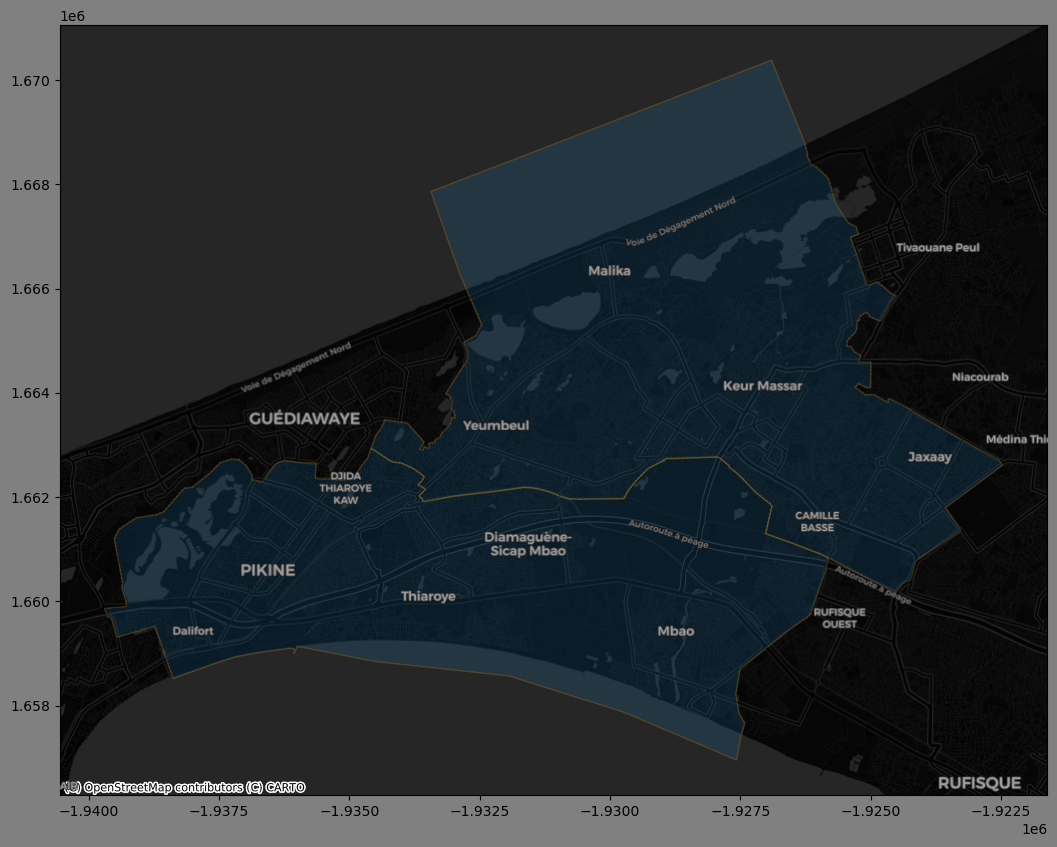

In [8]:
fig,ax=plt.subplots()

city = region.to_crs(3857)

city.plot(ax=ax,alpha=0.2,edgecolor='orange')

ctx.add_basemap(ax=ax, crs=city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(ax=ax, crs=city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

In [9]:
region_mapped = mapping(region.geometry.unary_union.buffer(20).buffer(-20))

In [19]:
region_mapped

{'type': 'Polygon',
 'coordinates': (((-17.3937953165305, 14.759545483361041),
   (-17.39339688101074, 14.760002978665645),
   (-17.358695974685883, 14.793354055402046),
   (-17.3201478790675, 14.805648316119731),
   (-17.305198799106268, 14.777230460715616),
   (-17.327343489735448, 14.747310733155738),
   (-17.364389625157457, 14.750587963683351),
   (-17.39218943507673, 14.755797396415039),
   (-17.3937953165305, 14.759545483361041)),)}

In [29]:
search = catalog.search(
    collections=["hrea"], intersects=region_mapped, datetime=["2012-12-31","2019-12-31"]
)

# Check how many items were returned, there could be more pages of results as well
items = search.item_collection()

# items

In [13]:
print('\n Number of items :',len(items),'\n')

display.GeoJSON(items.to_dict())# to display the scenes' footprint


 Number of items : 8 



<IPython.display.GeoJSON object>

In [14]:
data_assets = [
    f"{key}: {asset.title}"
    for key, asset in items[0].assets.items()
    if "data" in asset.roles
]

print(*data_assets, sep="\n")

lightscore: Probability of electrification
light-composite: Nighttime light annual composite
night-proportion: Proportion of nights a settlement is brighter than uninhabited areas
estimated-brightness: Estimated brightness levels


In [16]:
import stackstac

%time

PK_Km = (
    stackstac.stack(items, bounds_latlon = country.total_bounds) # assets=["light-composite"] we can specify the asset we want
    .squeeze()
    .compute()
)

# PK_Km

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


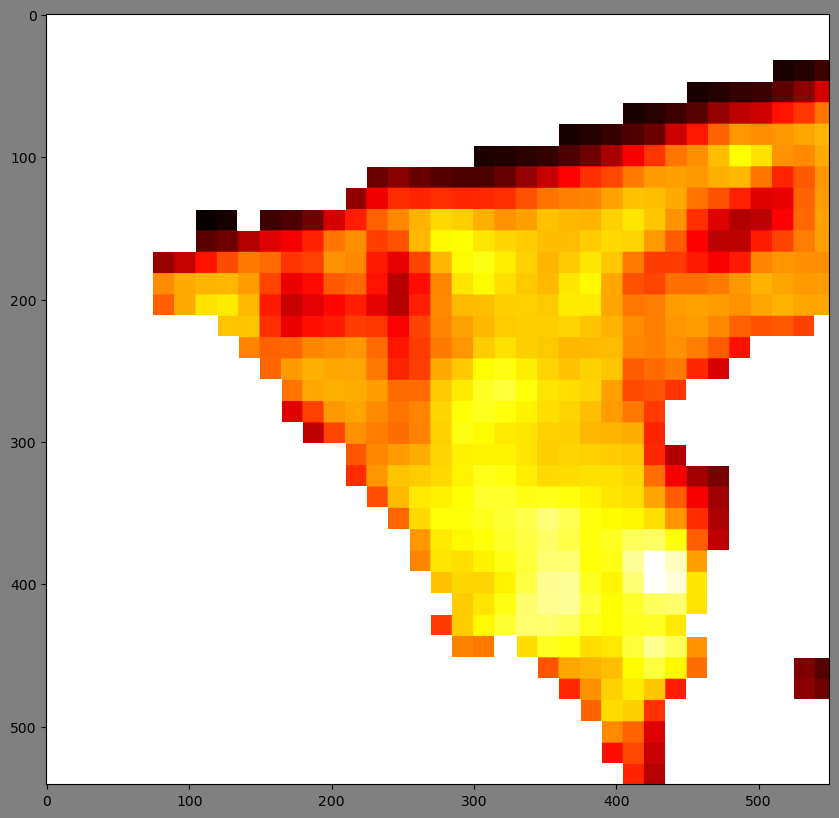

In [17]:
plt.imshow(PK_Km[7,1,:,:], cmap='hot')


In [88]:
# PK_Km.crs = {'epsg:3857'}

In [18]:

print(columnize(dir(rasterio.mask), displaywidth=150))

WindowError   __cached__  __file__    __name__     __spec__       geometry_window  logging  numpy                 rasterio
__builtins__  __doc__     __loader__  __package__  geometry_mask  logger           mask     raster_geometry_mask  warnings



In [26]:
# masked, mask_transform = rasterio.mask.mask(dataset=PK_Km[:,2,:,:], 
#                               shapes=region.geometry, crop=True)

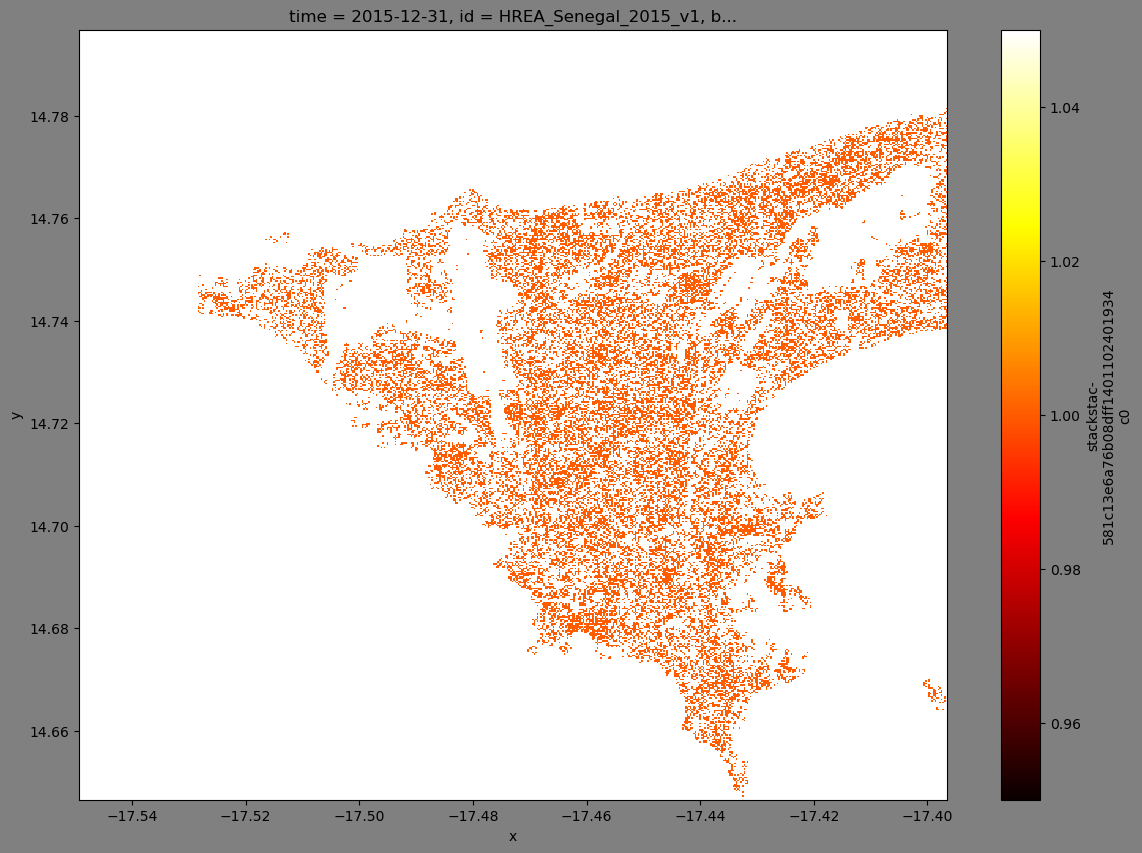

In [19]:
PK_Km[3,0,:,:].plot(cmap='hot')

In [70]:
# PK_Km.rio.write_crs('epsg:3857',inplace=True)

In [20]:
clipped1 = PK_Km.rio.clip(country.geometry.apply(mapping), country.crs, drop=False, invert=False)

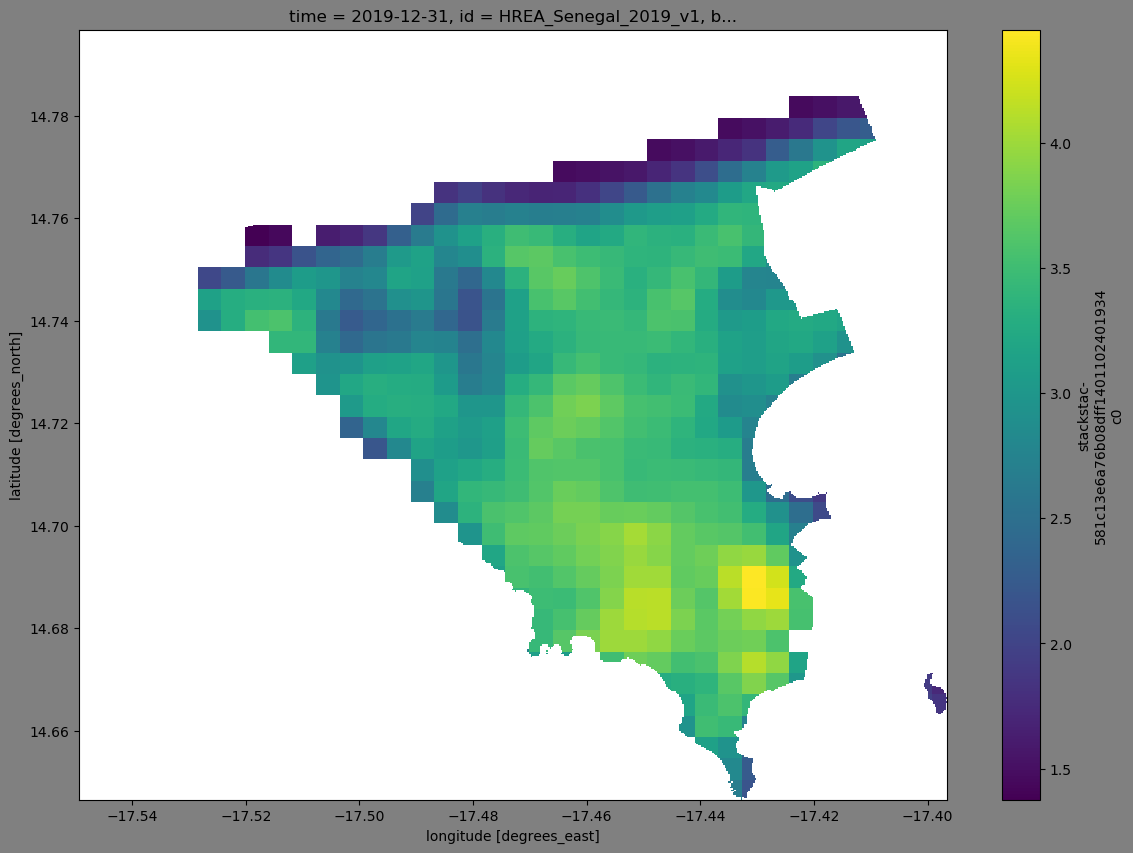

In [21]:
clipped1[7,1,:,:].plot()

In [22]:
routes= ox.graph_from_polygon(country.geometry[0],network_type='drive')

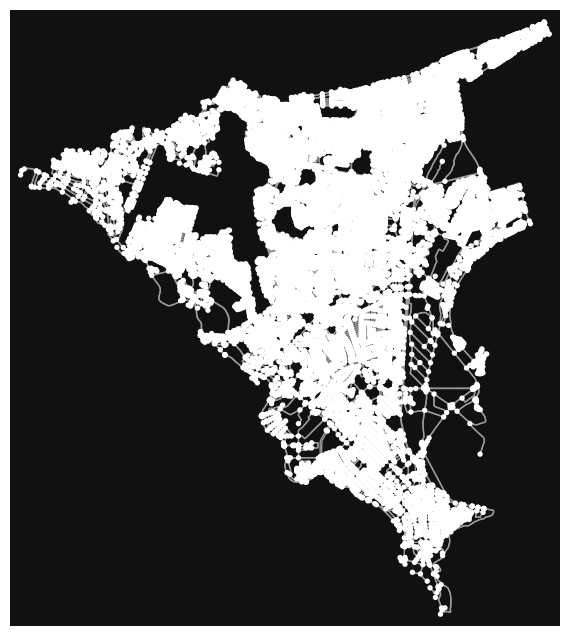

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [23]:
ox.plot_graph(routes)

In [24]:
routes_dk=ox.graph_to_gdfs(routes)[1]

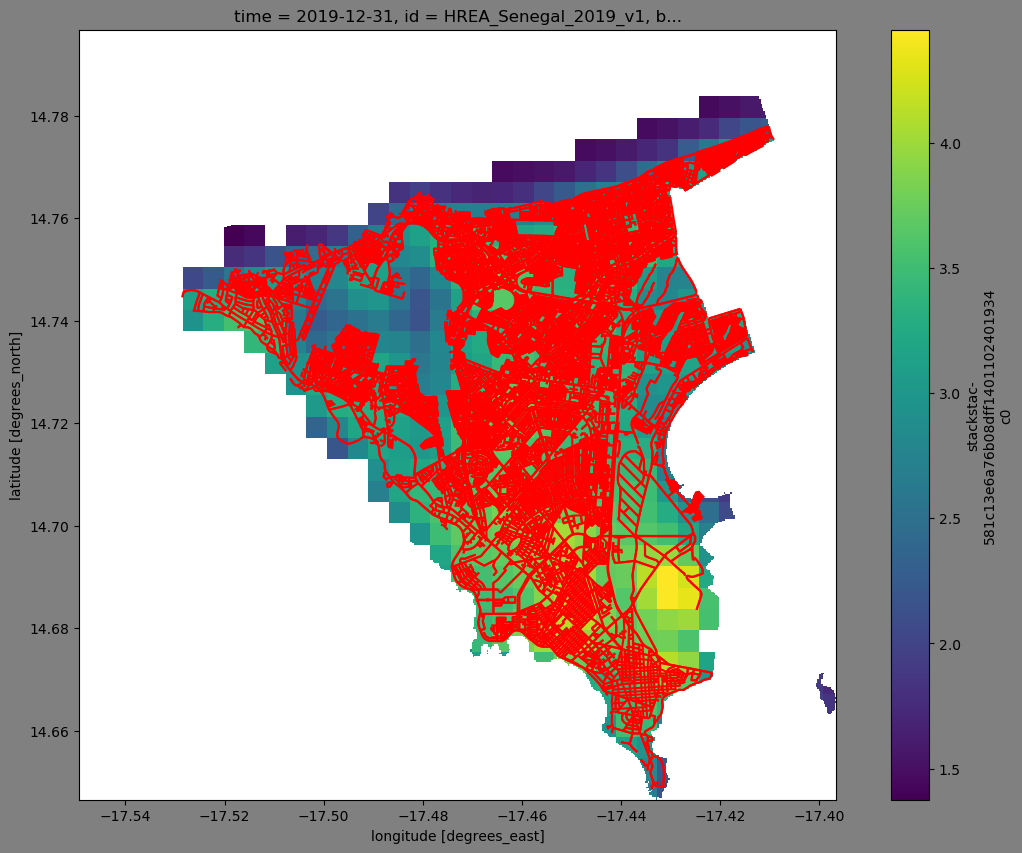

In [25]:
routes_dk.plot(color='red')
clipped1[7,1,:,:].plot()

In [26]:
clipped2 = clipped1.rio.clip(routes_dk.geometry.apply(mapping), routes_dk.crs, drop=False, invert=False)

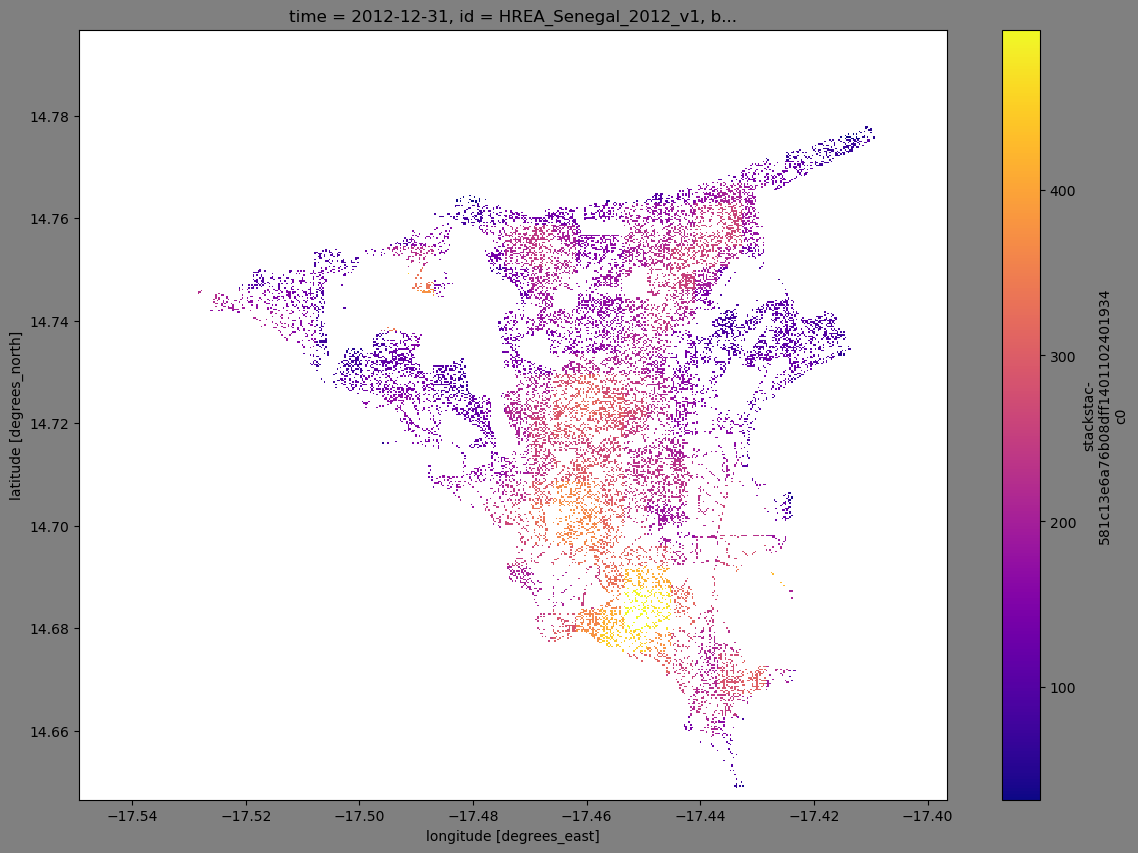

In [27]:
clipped2[0,3,:,:].plot(cmap='plasma')

In [28]:
night_lights_road=clipped2[7,1,:,:].to_pandas().stack().reset_index().rename(columns={'x': 'lng', 'y': 'lat', 0: 'light_score'}).dropna()

In [129]:
# lights_road=gpd.GeoDataFrame(night_lights_road,geometry=gpd.points_from_xy(night_lights_road.lng,night_lights_road.lat))

In [131]:
# night_lights_road.to_csv('night_lights_road.csv')